In [ ]:
#Import and setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from xgboost import XGBClassifier

# Optional: nicer display
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [5]:
# Load data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", pd.NA), errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df = df.drop(columns=['customerID'])
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# One-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)


In [8]:
# Train/Test Split

# Define features (X) and target (y)
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

# Split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (5625, 30)
Test set size: (1407, 30)


In [9]:
# Baseline Model: Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

ROC AUC: 0.8168449197860962


In [12]:
# Train XGBoost Model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.59      0.55      0.57       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407

ROC AUC: 0.8196701368217795


In [15]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


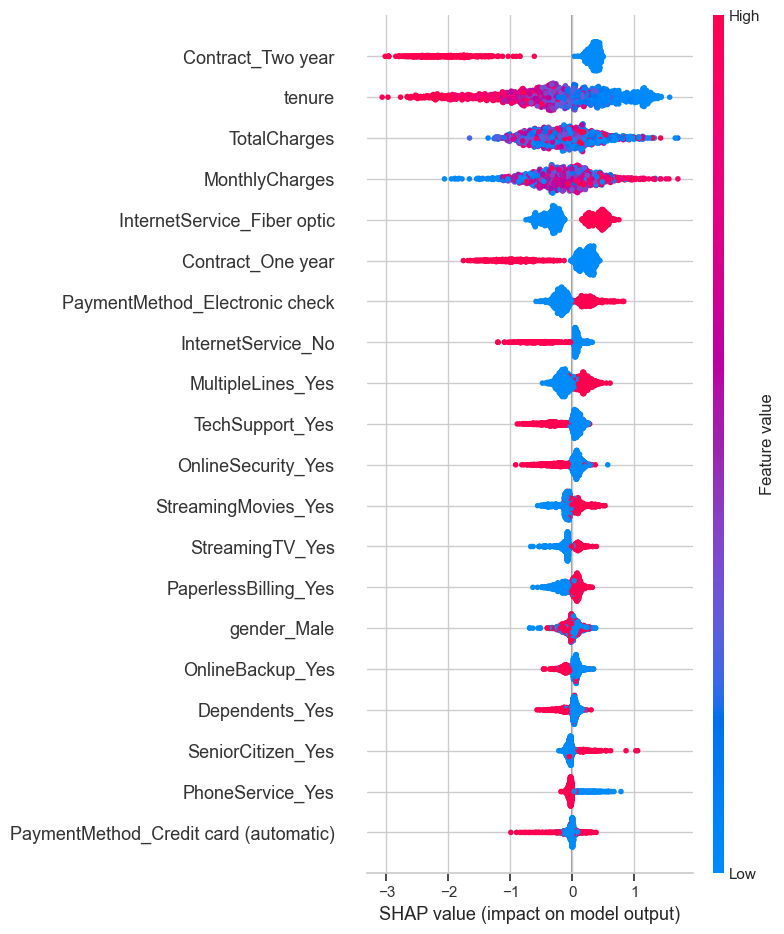

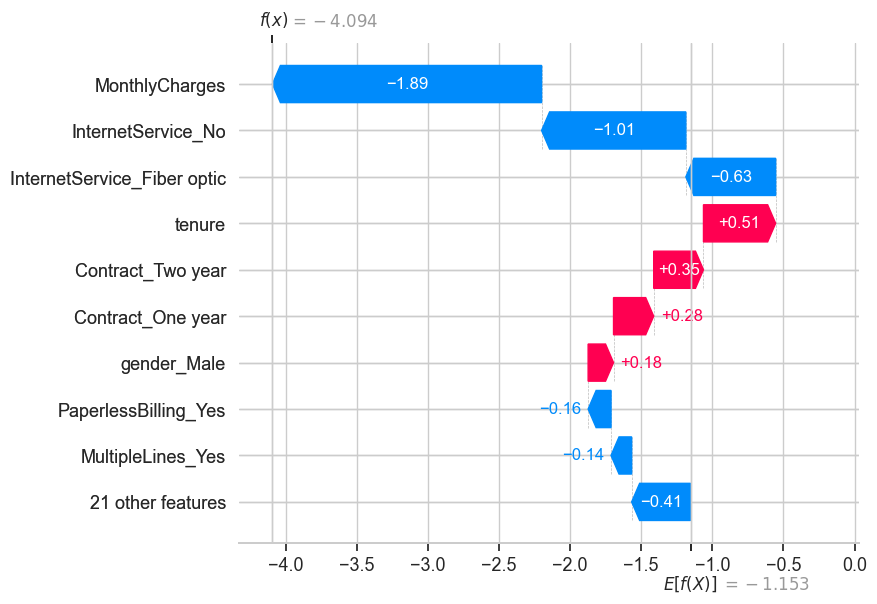

In [13]:
import shap

# Global explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# 📊 Summary Plot - Feature Importance
shap.summary_plot(shap_values, X_test)

# 🔍 Local Prediction - Waterfall Plot
sample = X_test[y_test == 1].iloc[0:1]  # a churned customer
sample_shap = explainer.shap_values(sample)

shap.initjs()
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, 
    sample_shap[0], 
    feature_names=sample.columns
)


In [14]:
import joblib

# Save model
joblib.dump(xgb, "churn_model.pkl")


['churn_model.pkl']